# Model performance

## Basic model performance after deconfounding
i.e. the main results

In [1]:
import pandas as pd
import numpy as np

phenotype = 'group'
denoise = "simple+gsr"
resample_list = [0, 100, 150, 200, 250, 300]

# load results
in_path = '../results/model_performance/'
in_dfs = {'accuracy': [], 'roc': [], 'confounders': []}
for model in ["logreg", "multilayer_metamatch"]:
    for resample in resample_list:
        if resample != 0:
            in_file = f"model-{model}_phenotype-{phenotype}_denoise-{denoise}_N{resample}.csv"
        else:
            in_file = f"model-{model}_phenotype-{phenotype}_denoise-{denoise}.csv"

        for i in ['accuracy', 'roc']:
            _df = pd.read_csv(in_path+i+'_'+in_file)
            _df['resample'] = resample
            in_dfs[i].append(_df)

        if resample == 0:
            i = 'confounders'
            _df = pd.read_csv(in_path+i+'_'+in_file)
            _df['resample'] = resample
            in_dfs[i].append(_df)

accuracy_df = pd.concat(in_dfs['accuracy'], axis=0, ignore_index=True)
roc_df = pd.concat(in_dfs['roc'], axis=0, ignore_index=True)
confounders_df = pd.concat(in_dfs['confounders'], axis=0, ignore_index=True)

## Statistics

In [2]:
import numpy as np
from scipy.stats import t

def CBIG_corrected_resampled_ttest(accuracy_vec, portion, threshold):
    """
    This function tests whether an accuracy vector (obtained from cross-validation) 
    is statistically different from a threshold. The accuracy vector can also
    represent the difference between two classifiers. The key point of this
    function is that it tries to correct for the dependencies between the
    folds, because the sample variance across folds underestimates the true
    variance.

    Parameters:
    accuracy_vec : numpy array of shape (K,), K is the number of folds.
    portion      : float, # test subjects/# training subjects for each cross-validation folds. E.g. portion for 5-fold CV equals 1/4 = 0.25
    threshold    : float, Null hypothesis: mean(accuracy_vec) 

    Returns:
    p            : float, 2-sided p value
    """

    K = len(accuracy_vec)
    assert K > 1, 'Number of folds must be greater than 1'

    # corrected variance
    corrected_variance = (1/K + portion) * np.var(accuracy_vec)

    # tstat
    mu = np.mean(accuracy_vec)
    tval = (mu-threshold) / np.sqrt(corrected_variance)

    # 2-tail p value (degree of freedom is K - 1)
    p = 2 * t.cdf(-abs(tval), K-1)

    return mu, tval, p

### Comparison to permutations and basic model performance
Generally using median rather than means.

In [7]:
import pingouin as pg 

# Comparison between full models and null (percentiles)
models = ['logreg_site_confounds_removed',
          'multilayer_metamatch_site_confounds_removed']

stats_result = pd.DataFrame(columns=['Logistic Regression', 'Meta-match'])

print("Percentile compared to shuffled models:")
for meas in ['acc', 'roc_auc']:
    print(meas)
    for model in models:
        print(model)
        df = accuracy_df.loc[(accuracy_df.model == model)
                            & (accuracy_df["resample"] == 0)]
        value = df.loc[df.permuted == False, meas].median()
        null_distribution = df.loc[df.permuted == True, meas].values 
        percentile = (null_distribution < value).mean()
        p_val = (0.5 - (abs(percentile - 0.5))) # Express similar to a p value regardless of direction
        print('\t', percentile, 'p=', p_val.round(4))
        print(df.loc[df.permuted == True, meas].median()) # check it is 50% for BACC

        # Thomas's resampled t-test
        mu, tval, p = CBIG_corrected_resampled_ttest(df.loc[df.permuted == False, meas].values, 1/4, 0.5)
        print("Resampled p=",p.round(2))

for model in models:
    print(model)
    for meas in ['acc', 'roc_auc', 'sensitivity', 'specificity']:
        value = accuracy_df.loc[(accuracy_df.model == model)
                            & (accuracy_df["resample"] == 0)
                            & (accuracy_df.permuted == False), meas].median()
        print('\t',meas,round(value,2))

print('% Median difference in raw performance')
meas = 'acc'
data = accuracy_df.loc[(accuracy_df.model == 'logreg_site_confounds_removed')
                        & (accuracy_df["resample"] == 0)
                        & (accuracy_df["permuted"] == False),
                        meas].median()
data2 = accuracy_df.loc[(accuracy_df.model == 'multilayer_metamatch_site_confounds_removed')
                        & (accuracy_df["resample"] == 0)
                        & (accuracy_df["permuted"] == False),
                        meas].median()
print("lr =", round(data, 4)*100)
print("mm =", round(data2, 4)*100)
print("diff =",round(((data - data2) * 100), 4))
        

Percentile compared to shuffled models:
acc
logreg_site_confounds_removed
	 1.0 p= 0.0
0.5
Resampled p= 0.0
multilayer_metamatch_site_confounds_removed
	 0.997 p= 0.003
0.5
Resampled p= 0.0
roc_auc
logreg_site_confounds_removed
	 1.0 p= 0.0
0.4625208596346117
Resampled p= 0.0
multilayer_metamatch_site_confounds_removed
	 0.997 p= 0.003
0.4879195330414843
Resampled p= 0.0
logreg_site_confounds_removed
	 acc 0.63
	 roc_auc 0.71
	 sensitivity 0.79
	 specificity 0.49
multilayer_metamatch_site_confounds_removed
	 acc 0.61
	 roc_auc 0.7
	 sensitivity 0.77
	 specificity 0.46
% Median difference in raw performance
lr = 63.29
mm = 61.07
diff = 2.2277


0.4879195330414843

### Comparison between models across each sample size

In [4]:
import pingouin as pg 

stats_table = pd.DataFrame(columns=['Sample', 'Measure', 'Logistic Regression', 'Meta-matching'])
accuracy_df['acc_fmt'] = accuracy_df.acc.copy() * 100

for r in accuracy_df["resample"].unique():
    for meas in ['acc_fmt', 'roc_auc']:

        # LR model
        model = 'logreg_site_confounds_removed'
        data = accuracy_df.loc[(accuracy_df.model == model)
                                & (accuracy_df["resample"] == r)
                                & (accuracy_df["permuted"] == False),
                                meas]
        median = np.round(data.median(), 2)
        quantile_low = np.round(data.quantile(0.25), 2)
        quantile_high = np.round(data.quantile(0.75), 2)

        model = 'multilayer_metamatch_site_confounds_removed'
        data2 = accuracy_df.loc[(accuracy_df.model == model)
                                & (accuracy_df["resample"] == r)
                                & (accuracy_df["permuted"] == False),
                                meas]
        median2 = np.round(data2.median(), 2)
        quantile_low2 = np.round(data2.quantile(0.25), 2)
        quantile_high2 = np.round(data2.quantile(0.75), 2)

        # comparison
        #result = pg.ttest(data, data2)

        # Thomas's resampled t-test
        diff_array = data.values - data2.values
        mu, tval, p = CBIG_corrected_resampled_ttest(diff_array, 1/4, 0)
        median3 = np.round(np.median(diff_array), 2)
        quantile_low3 = np.round(np.quantile(diff_array, 0.25), 2)
        quantile_high3 = np.round(np.quantile(diff_array, 0.75), 2)

        # append
        _df = pd.DataFrame()
        _df['Sample'] = [r]
        _df['Measure'] = meas
        _df['Logistic Regression'] = f"{median} ({quantile_low} - {quantile_high})"
        _df['Meta-matching'] = f"{median2} ({quantile_low2} - {quantile_high2})"
        _df['Diff'] = f"{median3} ({quantile_low3} - {quantile_high3})"
        _df["t"] = np.round(tval, 2)
        _df['p'] = np.round(p,2)
        stats_table = pd.concat([stats_table, _df])
display(stats_table)
stats_table.to_csv('../results/figures/model_performance.csv', index=False)

,Sample,Measure,Logistic Regression,Meta-matching,Diff,t,p
0,0,acc_fmt,63.29 (59.44 - 66.83),61.07 (57.92 - 65.06),2.03 (-2.06 - 5.59),0.63,0.53
0,0,roc_auc,0.71 (0.66 - 0.75),0.7 (0.66 - 0.74),0.0 (-0.04 - 0.05),0.28,0.78
0,100,acc_fmt,58.33 (50.0 - 65.16),50.0 (50.0 - 59.62),5.0 (-4.06 - 13.68),0.74,0.46
0,100,roc_auc,0.67 (0.57 - 0.75),0.6 (0.49 - 0.68),0.06 (-0.05 - 0.2),0.70,0.48
0,150,acc_fmt,61.31 (55.56 - 66.07),55.01 (50.0 - 61.39),6.37 (-2.85 - 13.34),0.91,0.36
0,150,roc_auc,0.68 (0.62 - 0.75),0.62 (0.54 - 0.69),0.09 (-0.04 - 0.18),0.99,0.32
0,200,acc_fmt,61.33 (56.01 - 66.17),56.53 (52.02 - 63.78),2.81 (-3.6 - 10.01),0.59,0.55
0,200,roc_auc,0.67 (0.61 - 0.73),0.65 (0.59 - 0.72),0.02 (-0.07 - 0.11),0.28,0.78
0,250,acc_fmt,60.19 (56.15 - 64.9),58.15 (53.01 - 63.06),2.49 (-3.64 - 8.47),0.48,0.63
0,250,roc_auc,0.68 (0.63 - 0.73),0.66 (0.6 - 0.72),0.01 (-0.06 - 0.08),0.31,0.76


## Plots

/home/lukeh/miniconda3/envs/MetaMatch/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/tmp/ipykernel_3413903/522015760.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'].replace('multilayer_metamatch_site_confounds_removed',
/tmp/ipykernel_3413903/522015760.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'].replace('logreg_site_confounds_removed',
/tmp/ipykernel_3413903/522015760.py:82: SettingWithC

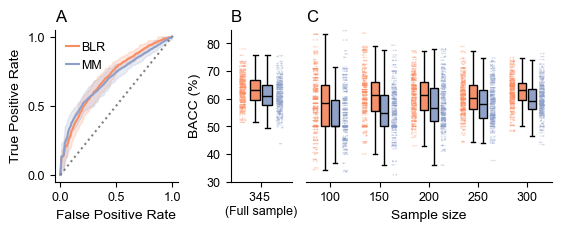

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
# create figure
fig, axs = plt.subplot_mosaic("""
                              AABCCCC
                              """,figsize=(5.5, 2.2), constrained_layout=True)
pal = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]]


## AUC plot
ax = axs['A']

# Filter the results df
df = roc_df.loc[
    (roc_df['model'].isin(models))
    & (roc_df['resample'] == 0)]

# Edit the df so that the legend is correct
df['model'].replace('multilayer_metamatch_site_confounds_removed',
                    'MM', inplace=True)
df['model'].replace('logreg_site_confounds_removed',
                    'BLR', inplace=True)

# organise data for the roc line plot
base_fpr = np.linspace(0, 1, 101)
df_fpr = pd.DataFrame()

# loop through folds and its
for i in range(100):
    for f in range(5):
        for model in ["BLR", "MM"]:
            data = df.loc[(df.fold == 0) & (df.iteration == i)
                        & (df.model == model) & (df.permuted == False)]
            fpr = data.fpr.values
            tpr = data.tpr.values
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            _df = pd.DataFrame()
            _df["tpr"] = tpr
            _df["fpr"] = base_fpr
            _df["model"] = model
            df_fpr = pd.concat([df_fpr, _df])

# line plot
sns.lineplot(ax=ax,
             data=df_fpr, 
             x='fpr',
             y='tpr',
             hue='model',
             hue_order=['BLR', 'MM'],
             palette=pal,
             errorbar=("pi", 50),
             legend=True)

ax.plot([0,1], [0,1], color='grey', linestyle='dotted')

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("True Positive Rate", fontsize=10)
ax.set_yticks(np.linspace(0, 1, 3))
ax.set_yticklabels(np.linspace(0, 1, 3))

ax.set_xlabel("False Positive Rate", fontsize=10)
ax.set_xticks(np.linspace(0, 1, 3))
ax.set_xticklabels(np.linspace(0, 1, 3))
ax.set_title('A', loc='left', fontsize=12)
sns.despine(ax=ax)

# Legend
ax.legend(frameon=False, loc='upper left', ncol=1,
          fontsize=9, handlelength=1, handletextpad=0.2)

# Balanced accuracy plot
ax = axs['B']

# Filter the results df
df = accuracy_df.loc[
    (accuracy_df['model'].isin(models))
    & (accuracy_df['resample'] == 0)]
df['acc_fmt'] = df.acc.values * 100

## Balanced Accuracy plot
# Draw the two models of interest
sns.boxplot(data=df.loc[df.permuted == False],
            ax=ax,
            y='acc_fmt',
            hue='model',
            hue_order=models,
            palette=pal,
            boxprops={'zorder': 1},
            saturation=0.9,
            fliersize=0,
            linecolor='k',
            linewidth=1,
            width=0.4,
            gap=0.2,
            legend=False)

sns.stripplot(data=df.loc[df.permuted == False],
            ax=ax,
            y='acc_fmt',
            hue='model',
            hue_order=models,
            palette=pal,
            dodge=True,
            zorder=0,
            size=1,
            alpha=0.25,
            jitter=True,
            legend=False)

offsets = [-0.1, 0.1, -0.1, 0.1]
for dots, off in zip(ax.collections, offsets):
    dots.set_offsets(dots.get_offsets() + np.array([off, 0]))

# # plot permutations
# sns.stripplot(data=df.loc[df.permuted == True],
#             ax=ax,
#             y='acc_fmt',
#             hue='model',
#             hue_order=models,
#             palette=['grey', 'grey'],
#             dodge=True,
#             zorder=0,
#             size=1,
#             alpha=0.05,
#             jitter=0.3,
#             legend=False)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_xticklabels(["345 \n(Full sample)"])
ax.set_ylabel("BACC (%)", fontsize=10)
ax.set_xlabel("", fontsize=10)
ax.set_ylim(30, 85)
ax.set_title('B', loc='left', fontsize=12)
sns.despine(ax=ax)

# Balanced accuracy across sampling
ax = axs['C']

# Filter the results df
df = accuracy_df.loc[
    (accuracy_df['model'].isin(models))
    & (accuracy_df['resample'] != 0)]
df['acc_fmt'] = df.acc.values * 100

## Balanced Accuracy plot
# Draw the two models of interest
sns.boxplot(data=df.loc[df.permuted == False],
            ax=ax,
            x='resample',
            y='acc_fmt',
            hue='model',
            hue_order=models,
            palette=pal,
            boxprops={'zorder': 1},
            saturation=0.9,
            fliersize=0,
            linecolor='k',
            linewidth=1,
            width=0.4,
            gap=0.2,
            legend=False)

sns.stripplot(data=df.loc[df.permuted == False],
            ax=ax,
            x='resample',
            y='acc_fmt',
            hue='model',
            hue_order=models,
            palette=pal,
            dodge=True,
            zorder=0,
            size=1,
            alpha=0.25,
            jitter=True,
            legend=False)

offsets = [-0.1, 0.1, -0.1, 0.1, 
           -0.1, 0.1, -0.1, 0.1,
           -0.1, 0.1]
for dots, off in zip(ax.collections, offsets):
    dots.set_offsets(dots.get_offsets() + np.array([off, 0]))

#ax.plot([-.5, 4.5], [50,50], color='grey', linestyle='dotted',zorder=0)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("")
ax.set_yticks([])
ax.set_xlabel("Sample size", fontsize=10)
ax.set_ylim(30, 85)
ax.set_title('C', loc='left', fontsize=12)
sns.despine(ax=ax, left=True)
plt.savefig('../results/figures/model_performance.svg')
plt.savefig('../results/figures/model_performance.jpeg', dpi=600)
plt.show()

## Effect of confounders and generalisation

### Stats prior to deconfounding

In [6]:
import pingouin as pg 

# Comparison between full models and null (percentiles)
# models = [,
#           'metamatch_site_confounds_removed']

stats_table = pd.DataFrame(columns=['Sample', 'Measure', 'Logistic Regression', 'Meta-matching'])
#accuracy_df = pd.concat(in_dfs['accuracy'], axis=0, ignore_index=True)
accuracy_df['acc_fmt'] = accuracy_df.acc.copy() * 100

for r in accuracy_df["resample"].unique():
    for meas in ['acc_fmt', 'roc_auc']:

        # LR model
        model = 'logreg'
        data = accuracy_df.loc[(accuracy_df.model == model)
                                & (accuracy_df["resample"] == r)
                                & (accuracy_df["permuted"] == False),
                                meas]
        median = np.round(data.median(), 2)
        quantile_low = np.round(data.quantile(0.25), 2)
        quantile_high = np.round(data.quantile(0.75), 2)

        model = 'multilayer_metamatch'
        data2 = accuracy_df.loc[(accuracy_df.model == model)
                                & (accuracy_df["resample"] == r)
                                & (accuracy_df["permuted"] == False),
                                meas]
        median2 = np.round(data2.median(), 2)
        quantile_low2 = np.round(data2.quantile(0.25), 2)
        quantile_high2 = np.round(data2.quantile(0.75), 2)

        # comparison
        result = pg.ttest(data, data2)

        # append
        _df = pd.DataFrame()
        _df['Sample'] = [r]
        _df['Measure'] = meas
        _df['Logistic Regression'] = f"{median} ({quantile_low} - {quantile_high})"
        _df['Meta-matching'] = f"{median2} ({quantile_low2} - {quantile_high2})"
        _df['Cohen-d'] = np.round(result['cohen-d'].values, 2)
        stats_table = pd.concat([stats_table, _df])
display(stats_table)
#stats_table.to_csv('../results/figures/model_performance_.csv', index=False)

,Sample,Measure,Logistic Regression,Meta-matching,Cohen-d
0,0,acc_fmt,62.19 (58.59 - 65.51),61.62 (57.79 - 64.64),0.13
0,0,roc_auc,0.71 (0.67 - 0.75),0.7 (0.66 - 0.74),0.17
0,100,acc_fmt,51.77 (50.0 - 59.92),50.0 (50.0 - 58.4),0.20
0,100,roc_auc,0.62 (0.54 - 0.7),0.56 (0.47 - 0.66),0.36
0,150,acc_fmt,56.56 (50.0 - 62.46),54.24 (50.0 - 61.61),0.09
0,150,roc_auc,0.66 (0.58 - 0.72),0.63 (0.55 - 0.71),0.21
0,200,acc_fmt,57.46 (50.1 - 63.52),58.63 (51.4 - 64.45),0.06
0,200,roc_auc,0.65 (0.59 - 0.72),0.67 (0.6 - 0.72),0.07
0,250,acc_fmt,58.09 (53.39 - 62.48),57.35 (51.81 - 62.4),0.04
0,250,roc_auc,0.64 (0.59 - 0.69),0.66 (0.61 - 0.71),0.25


In [7]:

conf_stats = pd.DataFrame()
model_list = ['logreg', 'multilayer_metamatch', 'logreg_site_confounds_removed', 'multilayer_metamatch_site_confounds_removed']
for var in confounders_df.confound.unique():

    # additional row for formatting:
    _df = pd.DataFrame()
    _df['Variable'] = [var]
    conf_stats = pd.concat([conf_stats, _df])

    _df = pd.DataFrame()
    _df['Variable'] = [var+'_r2']

    for model in model_list:
        data = confounders_df.loc[(confounders_df.confound == var) &
                                (confounders_df.model == model) &
                                (confounders_df.permuted == False), "r2_yhat_c"]
        median = np.round(data.median(), 2)
        quantile_low = np.round(data.quantile(0.25), 4)
        quantile_high = np.round(data.quantile(0.75), 4)

        # append
        _df[model] = f"{median} ({quantile_low} - {quantile_high})"
    conf_stats = pd.concat([conf_stats, _df])

    # p-values
    _df = pd.DataFrame()
    _df['Variable'] = [var+'_p']

    for model in model_list:
        value = confounders_df.loc[(confounders_df.confound == var) &
                                (confounders_df.model == model) &
                                (confounders_df.permuted == False), "r2_yhat_c"].mean()
        null_distribution = confounders_df.loc[(confounders_df.confound == var) &
                                (confounders_df.model == model) &
                                (confounders_df.permuted == True), "r2_yhat_c"].values
        percentile = (null_distribution < value).mean()
        # append
        _df[model] = percentile
    conf_stats = pd.concat([conf_stats, _df])

conf_stats.to_csv('../results/figures/confounder_stats.csv', index=False)
conf_stats.head(100)

,Variable,logreg,multilayer_metamatch,logreg_site_confounds_removed,multilayer_metamatch_site_confounds_removed
0,gender,NaN,NaN,NaN,NaN
0,gender_r2,0.02 (0.0139 - 0.0249),0.0 (0.0024 - 0.0065),0.0 (0.0001 - 0.0007),0.0 (0.0001 - 0.0016)
0,gender_p,0.9908,0.8131,0.3233,0.4469
0,age,NaN,NaN,NaN,NaN
0,age_r2,0.05 (0.0464 - 0.0625),0.04 (0.0369 - 0.0486),0.01 (0.0111 - 0.0177),0.0 (0.0005 - 0.0021)
0,age_p,1.0,0.9998,0.9657,0.4938
0,avg_framewise_displacement,NaN,NaN,NaN,NaN
0,avg_framewise_displacement_r2,0.06 (0.0539 - 0.073),0.07 (0.0611 - 0.0764),0.01 (0.0097 - 0.0155),0.01 (0.004 - 0.0066)
0,avg_framewise_displacement_p,1.0,1.0,0.8243,0.607
0,handedness,NaN,NaN,NaN,NaN


/tmp/ipykernel_3413903/1691888163.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acc_fmt'] = df.acc.values * 100
/tmp/ipykernel_3413903/1691888163.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['model','deconfounded']] = df['model'].str.split('_site_confounds_',expand=True)
/tmp/ipykernel_3413903/1691888163.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

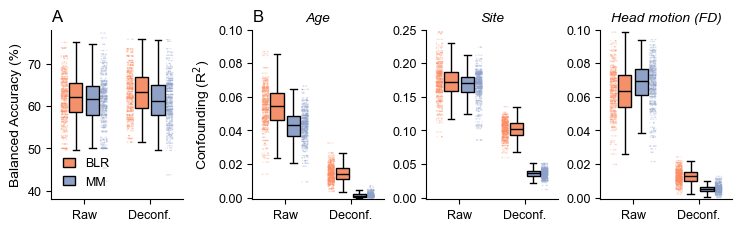

In [8]:
# Include both raw and deconfounded data
models = ['logreg', 'logreg_site_confounds_removed',
          'multilayer_metamatch', 'multilayer_metamatch_site_confounds_removed',]

# create figure
fig, axs = plt.subplot_mosaic("""
                              ABCD
                              """, figsize=(7.3, 2.2), constrained_layout=True)

# Accuracy plot
ax = axs['A']
# Filter the results df
df = accuracy_df.loc[
    (accuracy_df['model'].isin(models))
    & (accuracy_df['resample'] == 0)]
df['acc_fmt'] = df.acc.values * 100

# Reorganise so that deconfounding is a column
df[['model','deconfounded']] = df['model'].str.split('_site_confounds_',expand=True)
df.loc[df.deconfounded != 'removed', 'deconfounded'] = "Raw"
df.loc[df.deconfounded == 'removed', 'deconfounded'] = "Deconf."

# Plot shuffled data as another model
df['new_model'] = df['model']+df['permuted'].astype(str)

# Rename the models for the legend
df['new_model'].replace('logregFalse','BLR', inplace=True)
df['new_model'].replace('multilayer_metamatchFalse','MM', inplace=True)

sns.boxplot(data=df.loc[df.permuted == False],
            ax=ax,
            x='deconfounded',
            y='acc_fmt',
            hue='new_model',
            hue_order=['BLR', 'MM'],
            palette=pal,
            boxprops={'zorder': 1},
            saturation=0.9,
            fliersize=0,
            linecolor='k',
            linewidth=1,
            width=0.5,
            gap=0.2,
            legend=True)

sns.stripplot(data=df.loc[df.permuted == False],
            ax=ax,
            x='deconfounded',
            y='acc_fmt',
            hue='new_model',
            hue_order=['BLR', 'MM'],
            palette=pal,
            dodge=True,
            zorder=0,
            size=1,
            alpha=0.25,
            jitter=True,
            legend=False)

# # Give confound data hatches
# hatches = ["", "//////", "", "//////"]
# for hatch, patch in zip(hatches, ax.patches):
#     patch.set_hatch(hatch)

offsets = [-0.1, 0.1, -0.1, 0.1]
for dots, off in zip(ax.collections, offsets):
    dots.set_offsets(dots.get_offsets() + np.array([off, 0]))

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("Balanced Accuracy (%)", fontsize=10)
ax.set_xlabel("", fontsize=10)
ax.set_ylim(38, 78)
ax.set_title('A', loc='left', fontsize=12)
sns.despine(ax=ax)

# Legend
ax.legend(frameon=False, loc='lower left', ncol=1,
          fontsize=9, handlelength=1)

# Confound boxplots
axes_list = ['B', 'C', 'D']

# Rename confounds for nicer presentation
confounders_df.replace({'confound' : { 'site' : 'Site',
                                      'avg_framewise_displacement' : 'Head motion (FD)',
                                      'gender': 'Gender',
                                      'age': 'Age',
                                      'handedness': 'Handedness'
                                      }},
                                      inplace=True)

# Boxplot
confound_list = ['Age', 'Site', 'Head motion (FD)']
y_max = [0.10, 0.25, 0.1]
for i, confound in enumerate(confound_list):

    # Filter the results df
    df = confounders_df.loc[
        (confounders_df['model'].isin(models))
        & (confounders_df['confound'] == confound)]
    
    # Reorganise so that deconfounding is a column
    df[['model','deconfounded']] = df['model'].str.split('_site_confounds_',expand=True)
    df.loc[df.deconfounded != 'removed', 'deconfounded'] = "Raw"
    df.loc[df.deconfounded == 'removed', 'deconfounded'] = "Deconf."

    # Plot shuffled data as another model
    df['new_model'] = df['model']+df['permuted'].astype(str)

    ax = axs[axes_list[i]]
    sns.boxplot(ax=ax, 
                data=df.loc[df.permuted==False], 
                x='deconfounded',
                y='r2_yhat_c',
                palette=pal,
                hue='new_model',
                hue_order=['logregFalse', 'multilayer_metamatchFalse'],
                boxprops={'zorder': 1},
                saturation=0.9,
                fliersize=0,
                linewidth=1,
                linecolor='k',
                width=0.5,
                gap=0.2,
                legend=False)
    
    sns.stripplot(data=df.loc[df.permuted == False],
            ax=ax,
            x='deconfounded',
            y='r2_yhat_c',
            hue='new_model',
            hue_order=['logregFalse', 'multilayer_metamatchFalse'],
            palette=pal,
            dodge=True,
            zorder=0,
            size=1,
            alpha=0.25,
            jitter=True,
            legend=False)
    
    offsets = [-0.1, 0.1, -0.1, 0.1]
    for dots, off in zip(ax.collections, offsets):
        dots.set_offsets(dots.get_offsets() + np.array([off, 0]))
        
    # Formatting
    ax.tick_params(axis='both', which='major', labelsize=9)
    if axes_list[i] == 'B':
        ax.set_ylabel('Confounding (R$^2$)', fontsize=10)
        ax.set_title('B', loc='left', fontsize=12)
    else:
        ax.set_ylabel('', fontsize=10)
    sns.despine(ax=ax)
    ax.set_xlabel("", fontsize=10)
    ax.set_title(confound, fontsize=10, style='italic')
    ax.set_ylim(0-(y_max[i]*0.01), y_max[i])
        
plt.savefig('../results/figures/model_confounders.svg')
plt.savefig('../results/figures/model_confounders.jpeg', dpi=600)

plt.show()
